In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/helen-eye-dataset/train_4/train_4/2939530219_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2851045896_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2833382427_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2838782582_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2830081484_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/269968666_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2882152659_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2917878894_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2663129694_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/288344083_2.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2943361594_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/271207626_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/280005282_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2772487898_1.jpg
/kaggle/input/helen-eye-dataset/train_4/train_4/2659115078_1.jpg
/kaggle/input/helen-eye-datas

/kaggle/input/helen-eye-dataset/annotation/annotation/570.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1614.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/110.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1528.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/942.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1050.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1082.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1343.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/844.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/663.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/530.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/2040.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/966.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1837.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1775.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/43.txt
/

/kaggle/input/helen-eye-dataset/annotation/annotation/1357.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1755.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1333.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1728.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/2287.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/2269.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1564.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/569.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/842.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1030.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/401.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1685.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1454.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/123.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1793.txt
/kaggle/input/helen-eye-dataset/annotation/annotation/1909.

In [2]:
from PIL import Image, ImageDraw, ImageFont
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gc
import sys
import seaborn as sns
import cv2
import shutil
from glob import glob
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook as tqdm

In [55]:
PATH = '../input/helen-eye-dataset/annotation/annotation/'
IMAGEPATH = '../input/helen-eye-dataset/'
def getTable(path):
    anolist = glob(path + '*.txt')
    locations = np.array([readData(i) for i in anolist])
    print(locations.shape)
    ID = np.array([np.array(list(pd.read_csv(i).columns)) for i in anolist])
    df = pd.DataFrame()
    df ['id'] = ID.ravel()
    df['localtions'] = locations
    
    return df.dropna()
df_train = getTable(PATH)
df_train.head()

(2330,)


,id,localtions
0,2106789492_1,549.56 403.35 550.5 423.78 550.72 445.82 55...
1,2719473671_1,941.81 1094.23 948.81 1130.45 950.88 1171.3...
2,1207566864_1,282.65 291.69 283.99 308.81 285.34 327.65 2...
3,2665879761_1,116.93 593.25 119.75 618.19 123.64 643.18 1...
4,2330955410_1,291.3 458.65 294.91 476.29 298.07 494.56 30...


In [54]:
def readData(path):
    with open(path) as f:
        a = f.read().strip().split('\n')[1:]
    return re.sub(r'\,',''," ".join(a))

In [56]:
# Getting from reference 
marker_id = ['face', 'nose', 'mouth_inner', 'mouth_outer', 'r_eye', 'l_eye', 'r_eyebrow', 'l_eyebrow']
marker_split = np.cumsum([0, 41, 17, 28, 28, 20, 20, 20, 20])
print(marker_id[4],marker_split[4], ' to ', marker_split[5]) 
print(marker_id[5],marker_split[5], ' to ', marker_split[6]) 

r_eye 114  to  134
l_eye 134  to  154


In [13]:
lookup = {i.split('/')[-1].split('.')[0]: i for i in glob(IMAGEPATH + '*/*/*.jpg')}
def getEdge(x_y):
    print(x_y.shape)
    xmin, xmax = np.min(x_y[:,0]), np.max(x_y[:,0])
    ymin, ymax = np.min(x_y[:,1]), np.max(x_y[:,1])
    
    return (xmin,ymin,xmax-xmin,ymax-ymin)

## We have 2330 instances

In [58]:
fontsize = 50
def bboxVis(image,label):
    labels = np.array(label.split()).reshape(-1,2)
    print(labels.shape)
    left = labels[134:154].astype('float')
    #114, 134),
  #'l_eye': (134, 154)
    #print(left.shape)
    right = labels[114:134].astype('float')
    eyelist = [left,right]
    
    imsource = Image.open(image).convert('RGBA')
    bbox_canvas = Image.new('RGBA',imsource.size)
    char_canvas = Image.new('RGBA',imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas)
    char_draw = ImageDraw.Draw(char_canvas)
    
    for eye in eyelist:
        print(eye)
        x,y,w,h = getEdge(eye)
        print(w)
        
        bbox_draw.rectangle((x,y,x+w,y+h),fill = (255,255,255,0),outline = (255,0,0,255))
        char_draw.text((x+25,y-fontsize*(3/4)),f'eye',fill = (0,255,255))
    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas),char_canvas)
    return np.asarray(imsource.convert('RGB'))
    
    

(194, 2)
[[481.69 435.43]
 [480.73 429.71]
 [475.46 425.96]
 [470.16 422.27]
 [464.46 419.7 ]
 [458.06 418.71]
 [451.41 419.22]
 [445.26 420.7 ]
 [439.39 422.68]
 [433.71 425.33]
 [428.4  428.9 ]
 [424.84 434.21]
 [430.24 437.62]
 [436.21 439.49]
 [442.71 440.21]
 [449.59 440.21]
 [456.24 439.71]
 [462.62 438.71]
 [469.14 437.96]
 [475.54 436.96]]
(20, 2)
56.85000000000002
[[575.   424.87]
 [579.6  420.53]
 [584.4  416.72]
 [589.62 414.  ]
 [595.02 411.87]
 [601.08 411.12]
 [607.5  411.12]
 [613.42 412.11]
 [619.25 413.37]
 [624.7  415.36]
 [629.59 418.95]
 [628.2  424.41]
 [622.75 426.37]
 [617.05 427.87]
 [611.1  428.87]
 [604.92 429.37]
 [598.5  429.37]
 [592.33 428.87]
 [586.02 428.62]
 [580.33 427.1 ]]
(20, 2)
54.59000000000003


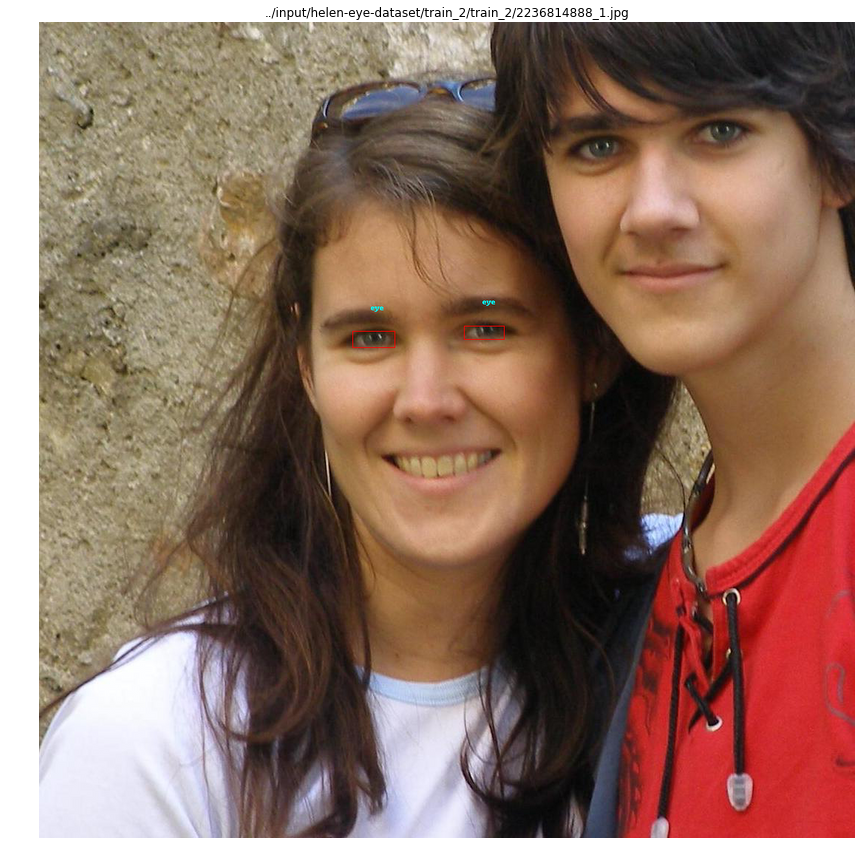

In [59]:
def show_result():
    img, labels = df_train.values[np.random.randint(len(df_train))]
    img = lookup.get(img)
    viz = bboxVis(img, labels)
    plt.figure(figsize=(15, 15))
    plt.title(img)
    plt.axis("off")
    plt.imshow(viz, interpolation='lanczos')
    plt.show()

show_result()